<a href="https://colab.research.google.com/github/enikolaev/ML_and_NN/blob/main/Practical_Work_Logic_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Логические модели классификации

## Импорт модулей

In [1]:
import numpy as np
from sklearn import datasets
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt

## Работа с датасетом

### Получение данных Ирисы Фишера

In [2]:
iris= datasets.load_iris()
print(iris.data.shape, type(iris.data))

(150, 4) <class 'numpy.ndarray'>


### Анализ dataset'а

In [35]:
def code_to_name(x):
  if x==0: return 'setosa'
  elif x==1: return 'versicolor'
  else: return 'virginica'

iris_frame = pd.DataFrame(iris.data, columns=['sepal_length','sepal_width', 'petal_length','petal_width'])
iris_frame['answer'] = iris.target
iris_frame['category'] = iris_frame['answer'].apply(code_to_name)
iris_frame.tail()


,sepal_length,sepal_width,petal_length,petal_width,answer,category
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica
149,5.9,3.0,5.1,1.8,2,virginica


In [13]:
dX = iris_frame.iloc[ : , 0:4 ]
dX.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [37]:
dy = iris_frame['category']
dy.head()

0    setosa
1    setosa
2    setosa
3    setosa
4    setosa
Name: category, dtype: object

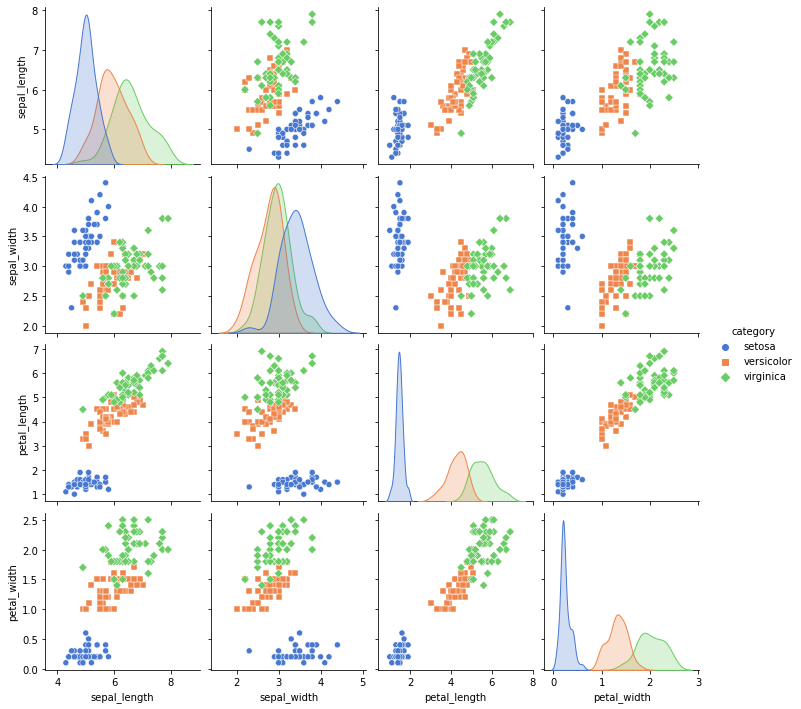

In [42]:
sb.pairplot(iris_frame[['sepal_length','sepal_width', 'petal_length','petal_width', 'category']], hue='category', markers=["o", "s", "D"], palette="muted")

## Классификация на основе решающего дерева

### Обучение классификатора на основе дерева решений

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Подмножества для hold-out
X_train, X_holdout, y_train, y_holdout = \
train_test_split(dX, dy, test_size=0.3, random_state=12)

# Обучение модели
tree = DecisionTreeClassifier(max_depth=5, 
                              random_state=21, 
                              max_features=2)
tree.fit(X_train, y_train)

# Получение оценки hold-out
tree_pred = tree.predict(X_holdout)
accur = accuracy_score(y_holdout, tree_pred)
print(accur)

0.9777777777777777


### Определение гипперпараметров для решающего дерева

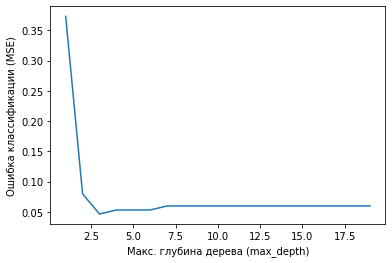

Оптимальные значения max_depth:  [3]


In [44]:
from sklearn.model_selection import cross_val_score

# Значения параметра max_depth
d_list = list(range(1,20))
# Пустой список для хранения значений точности
cv_scores = []
# В цикле проходим все значения K
for d in d_list:
    tree = DecisionTreeClassifier(max_depth=d, 
                                  random_state=21, 
                                  max_features=2)
    scores = cross_val_score(tree, dX, dy, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Вычисляем ошибку (misclassification error)
MSE = [1-x for x in cv_scores]

# Строим график
plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
d_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_d_min = []
for i in range(len(MSE)):
    if MSE[i] <= d_min:
        all_d_min.append(d_list[i])

# печатаем все K, оптимальные для модели
print('Оптимальные значения max_depth: ', all_d_min)

### Осуществляем поиск оптимальных гипперпараметров с использованием GridSearch

In [45]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree

dtc = DecisionTreeClassifier(max_depth=10, random_state=21, max_features=2)

tree_params = { 'max_depth': range(1,20), 'max_features': range(1,4) }
tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
tree_grid.fit(dX, dy)

print('\n')
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее сочетание параметров:  {'max_depth': 2, 'max_features': 3}
Лучшие баллы cross validation:  0.9533333333333334


### Обучение модели с оптимальной глубиной дерева

In [50]:
# Построим модель для оптимального дерева
# max_features = 3, max_depth = 2

dtc = DecisionTreeClassifier(max_depth=2, 
                             random_state=21, 
                             max_features=3)

### Выполнение предсказания

In [51]:
dtc.fit(dX, dy)
res = dtc.predict([[1.1, 3.5, 1.5, 0.2]])
print(res)

['setosa']


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


### Анализ границ классификатора на основе дерева решений

---



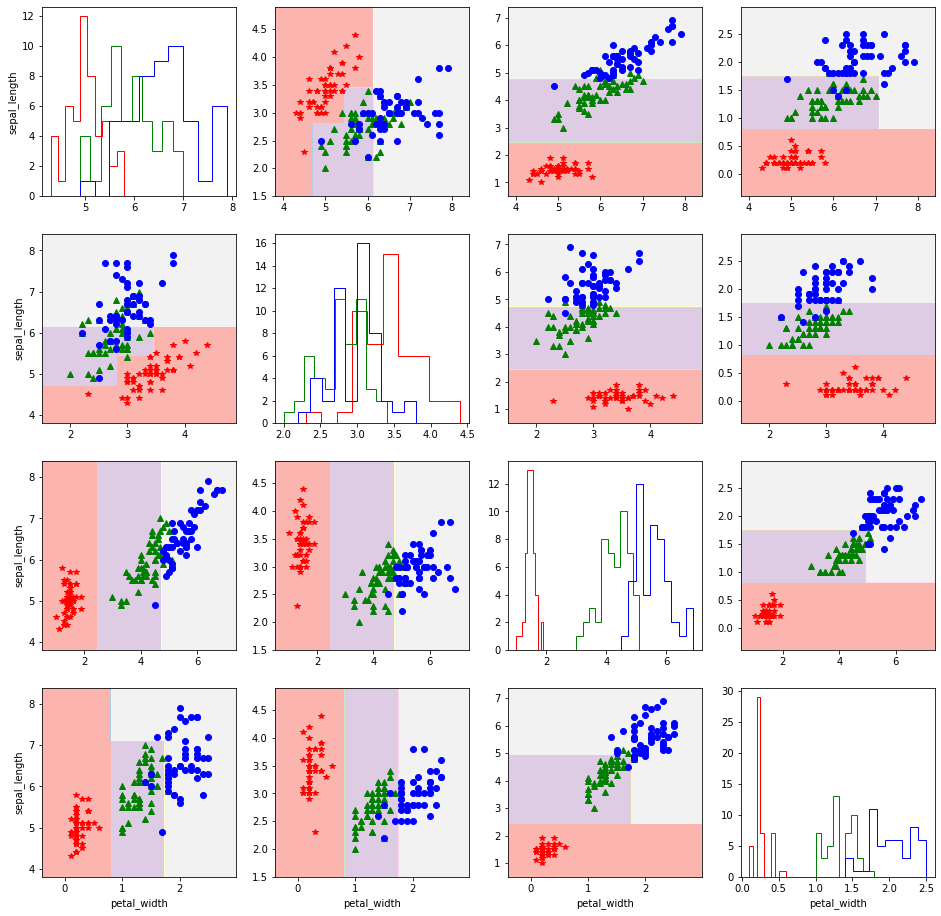

In [53]:
plot_markers = ['r*', 'g^', 'bo']
answers = dy.unique()

# Создаем подграфики для каждой пары признаков
f, places = plt.subplots(4, 4, figsize=(16,16))

fmin = dX.min()-0.5
fmax = dX.max()+0.5
plot_step = 0.02  

# Обходим все subplot
for i in range(0,4):
    for j in range(0,4):

        # Строим решающие границы 
        if(i != j):
            xx, yy = np.meshgrid(np.arange(fmin[i], fmax[i], plot_step),
                               np.arange(fmin[j], fmax[j], plot_step))
            model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
            model.fit(dX.iloc[:, [i,j]].values, dy)
            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)
            p[p==answers[0]] = 0
            p[p==answers[1]] = 1
            p[p==answers[2]] = 2
            places[i,j].contourf(xx, yy, p, cmap='Pastel1') 
      
        # Обход всех классов
        for id_answer in range(len(answers)):
            idx = np.where(dy == answers[id_answer])
            if i==j:
                places[i, j].hist(dX.iloc[idx].iloc[:,i],
                                  color=plot_markers[id_answer][0],
                                 histtype = 'step')
            else:
                places[i, j].plot(dX.iloc[idx].iloc[:,i], dX.iloc[idx].iloc[:,j], 
                                  plot_markers[id_answer], 
                                  label=answers[id_answer], markersize=6)
        
        if j==0:
            places[i, j].set_ylabel(dX.columns[j])
        
        if i==3:
            places[i, j].set_xlabel(dX.columns[i])

## Индивидуальное задание

После изучения и выполнения, представленных в данной работе приемов логической классификации, необходимо раелизовать следующие пункты:


*   выбрать свой собственный набор данных для логической классификации (синтетический или из внешнего источника)
* реализовать алгоритм логической классификации и аналих результатов
* сохранить Python Notebook в виде PDF-документа и загрузить полученный отчет в систему дистанционного обучения



